# Descretisizing the oil price as a factor-feature
>Objective: Define periods of time when the returns / STD / volatility / volume delopment in the oil price are abnormally large. >hese periods are defined binary:
> * normal volatility &rarr; 0
>
> * high volatility &rarr;1

In [254]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm

### Global variables

START = '2016-01-01'
END = datetime.today()
INTERVAL = '1d'
WINDOW_SIZE = 5
QUANTILE = 0.95
W_VOLUME = 0.4
W_PCT = 0.3
W_STD = 0.3
PAIR = 'ORK.OL BN.PA'

In [255]:
def z_score(series):
    """
    Calculates z-scores for a given timeseries
    
    Parameters
    -----------
    series : Pandas timeseries
        time series
        
    Returns
    -----------
    Pandas timeseries
        z-scores of series
    """
    return (series - series.mean()) / np.std(series)

def spread(S1, S2):

    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[PAIR.split()[0]]
    b = results.params[1]
    spread = S2 - b * S1

    
    return spread
 

### Data: Brent Crude oil and arbitrary company returns

In [256]:
data = yf.download(PAIR + ' BZ=F', start=START, end=END, interval=INTERVAL, rounding = True)\
         .drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)\
         .rename(columns={'BZ=F': 'Brent', 'ELK.OL': 'Elkem'})

data['Close'] = data['Close'].pct_change()
data = data.fillna(method='ffill')
data = data[2:]
data.head()

### close prices

data_close = yf.download(PAIR, start=START, end=END, interval=INTERVAL, rounding = True)\
         .drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

data_close = data_close.reindex(data.index, axis=0).fillna(method='ffill')

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed


In [257]:
data_close

Close       
            BN.PA ORK.OL
Date                    
2016-01-05  61.19  68.85
2016-01-06  60.70  68.25
2016-01-07  59.75  66.80
2016-01-08  59.73  66.55
2016-01-11  58.74  65.60
...           ...    ...
2022-01-19  57.16  86.18
2022-01-20  57.52  85.76
2022-01-21  57.84  86.40
2022-01-24  56.06  84.62
2022-01-25  56.26  85.34

[1567 rows x 2 columns]

In [258]:
### Reordering levels and sorting columns to the desirec format
data = data.reorder_levels(axis=1, order=[1,0])\
           .sort_index(axis=1)
data.head()

BN.PA                Brent             ORK.OL           
               Close     Volume     Close   Volume     Close     Volume
Date                                                                   
2016-01-05  0.006249  1805845.0 -0.021494  29327.0  0.003644  1247581.0
2016-01-06 -0.008008  1347397.0 -0.060132  43019.0 -0.008715  1079941.0
2016-01-07 -0.015651  1866401.0 -0.014023  44381.0 -0.021245  1439279.0
2016-01-08 -0.000335  2046098.0 -0.005926  39985.0 -0.003743  1336617.0
2016-01-11 -0.016575  1529267.0 -0.059613  38666.0 -0.014275  1532900.0

In [259]:
df_oil = data.Brent
df_pair = data.iloc[:, 2:]

<AxesSubplot:xlabel='Date'>

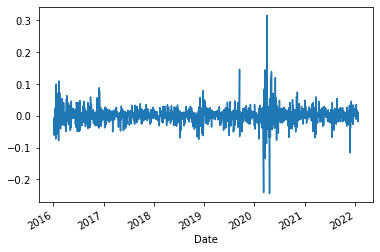

In [260]:
### Checking for pct_change distribution
df_oil.Close.plot()

<AxesSubplot:xlabel='Date'>

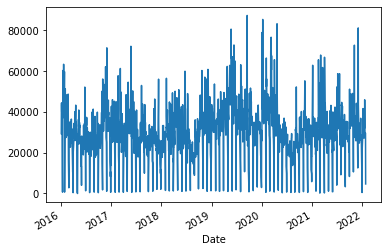

In [261]:
### Checking for the Volume distribution

df_oil.Volume.plot()

In [262]:
### Assigning new columns (as described in introduction)

df_oil = df_oil.assign(rolling_pct = df_oil['Close'].rolling(WINDOW_SIZE).mean(),
                       rolling_vol = df_oil['Volume'].rolling(WINDOW_SIZE).mean(),
                       rolling_std = df_oil['Close'].rolling(WINDOW_SIZE).std()
                      )
pct_bound = df_oil['rolling_pct'][WINDOW_SIZE:].quantile(QUANTILE)
std_bound = df_oil['rolling_std'][WINDOW_SIZE:].quantile(QUANTILE)
vol_bound = df_oil['rolling_vol'][WINDOW_SIZE:].quantile(QUANTILE)

df_oil = df_oil.assign(pct_level = np.where(abs(df_oil['rolling_pct']) > pct_bound, 1, 0),
                       vol_level = np.where(df_oil['rolling_vol'] > vol_bound, 1, 0),
                       std_level = np.where(df_oil['rolling_std'] > std_bound, 1, 0)
                      )
df_oil.head(10)

,Close,Volume,rolling_pct,rolling_vol,rolling_std,pct_level,vol_level,std_level
Date,,,,,,,,
2016-01-05,-0.021494,29327.0,NaN,NaN,NaN,0,0,0
2016-01-06,-0.060132,43019.0,NaN,NaN,NaN,0,0,0
2016-01-07,-0.014023,44381.0,NaN,NaN,NaN,0,0,0
2016-01-08,-0.005926,39985.0,NaN,NaN,NaN,0,0,0
2016-01-11,-0.059613,38666.0,-0.032237,39075.6,0.025821,1,0,0
2016-01-12,-0.021870,20138.0,-0.032313,37237.8,0.025783,1,0,0
2016-01-13,-0.017822,9674.0,-0.023851,30568.8,0.020839,1,0,0
2016-01-14,0.023755,663.0,-0.016295,21825.2,0.030089,1,0,0
2016-01-15,-0.000645,37163.0,-0.015239,21260.8,0.030631,0,0,0


In [263]:
df_oil['pct_level'].value_counts()

0    1412
1     155
Name: pct_level, dtype: int64

In [264]:
df_oil['vol_level'].value_counts()

0    1488
1      79
Name: vol_level, dtype: int64

In [265]:
df_oil['std_level'].value_counts()

0    1488
1      79
Name: std_level, dtype: int64

### Good (unused) functionality

In [266]:
# ### reindexing, forward-filling missing values and concatenating

# df_oil.reindex_like(df_sec).fillna(method='ffill', inplace=True)
# df_combined = pd.concat((df_oil, df_sec), axis=1)
# df_combined.head()

#### z_score

In [267]:
ratio = data_close.iloc[:,0] / data_close.iloc[:,1]
z = z_score(ratio)
z = pd.DataFrame(z, columns=['z_score']).fillna(method='ffill')
z;

#### Spread

In [268]:
S1 = data_close.Close[PAIR.split()[0]]
S2 = data_close.Close[PAIR.split()[1]]

s = spread(S1, S2)
s = pd.DataFrame(s)

C:\Users\Anders Huse\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### Plotting points on the ratio

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

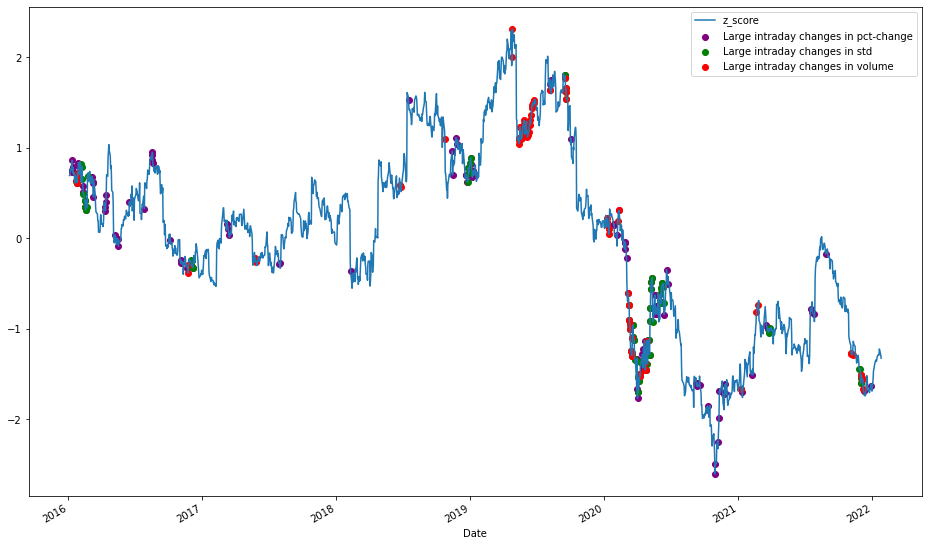

In [269]:
### index of extreme points
oil_pct_index = df_oil[df_oil['pct_level'] == 1].index
oil_std_index = df_oil[df_oil['std_level'] == 1].index
oil_vol_index = df_oil[df_oil['vol_level'] == 1].index

### Points on ratio
ex_points_pct = z.loc[oil_pct_index, :]
ex_points_std = z.loc[oil_std_index, :]
ex_points_vol = z.loc[oil_vol_index, :]


fig = plt.figure()

z.plot(figsize=(16,10), label='Elkem', ls = '-')

plt.scatter(ex_points_pct.index, ex_points_pct, c='purple',
            label='Large intraday changes in pct-change', marker = 'o')
plt.scatter(ex_points_std.index, ex_points_std, c='g',
            label='Large intraday changes in std', marker = 'o')
plt.scatter(ex_points_vol.index, ex_points_vol, c='r',
            label='Large intraday changes in volume', marker = 'o')

plt.legend();
# fig.show()

### Points on the spread

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

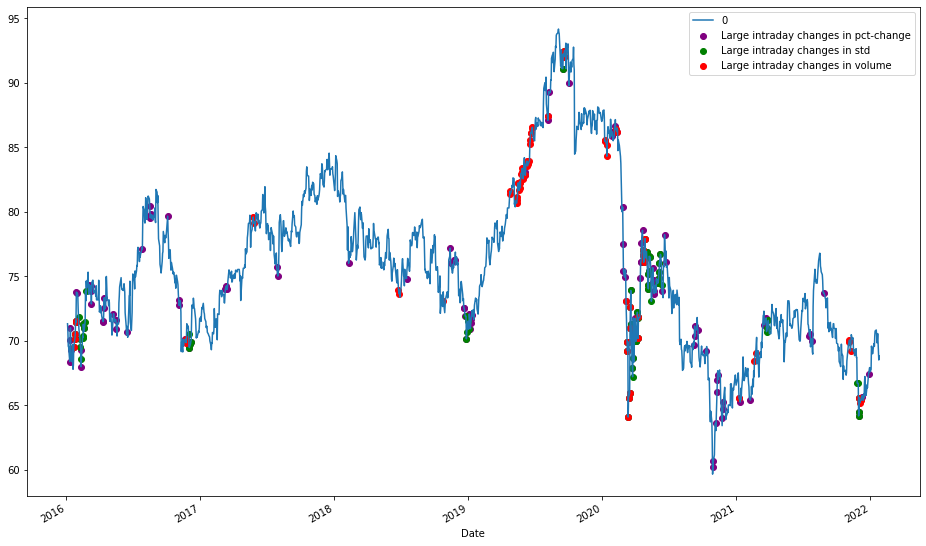

In [270]:
### Points on spread
ex_points_pct = s.loc[oil_pct_index, :]
ex_points_std = s.loc[oil_std_index, :]
ex_points_vol = s.loc[oil_vol_index, :]


fig = plt.figure()

s.plot(figsize=(16,10), label='Elkem')

plt.scatter(ex_points_pct.index, ex_points_pct, c='purple', label='Large intraday changes in pct-change')
plt.scatter(ex_points_std.index, ex_points_std, c='g', label='Large intraday changes in std')
plt.scatter(ex_points_vol.index, ex_points_vol, c='r', label='Large intraday changes in volume')

plt.legend();
# fig.show()

### Plotting combined &rarr; plotly

In [317]:
import plotly.graph_objects as go
import plotly.express as px

### index of extreme points
oil_pct_index = df_oil[df_oil['pct_level'] == 1].index
oil_std_index = df_oil[df_oil['std_level'] == 1].index
oil_vol_index = df_oil[df_oil['vol_level'] == 1].index

### Points on ratio
ex_points_pct = s.loc[oil_pct_index, :]
ex_points_std = s.loc[oil_std_index, :]
ex_points_vol = s.loc[oil_vol_index, :]


t_ = 'spread'
# t_ = 'ratio'

if t_ == 'spread':
    x, y = s.index, s[0]
else:
    x, y = z.index, z['z_score']
    
fig = px.line(x=x, y=y, labels={'y': f'{t_}'})

### traces (scatter points of extremes)
fig.add_trace(go.Scatter(x=ex_points_pct.index, y=ex_points_pct[0], marker_color = 'red', mode='markers', name = 'Percentage Change'))
fig.add_trace(go.Scatter(x=ex_points_std.index, y=ex_points_std[0], marker_color = 'green', mode='markers', name = 'STD Change'))
fig.add_trace(go.Scatter(x=ex_points_vol.index, y=ex_points_vol[0], marker_color = 'cyan', mode='markers', name = 'Volume (by size)'))

fig.update_traces(line=dict(color='blue', width=0.9))
fig.show()

In [272]:
s.index

DatetimeIndex(['2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-18',
               ...
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25'],
              dtype='datetime64[ns]', name='Date', length=1567, freq=None)

In [273]:
df_oil.index

DatetimeIndex(['2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-18',
               ...
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25'],
              dtype='datetime64[ns]', name='Date', length=1567, freq=None)

<AxesSubplot:xlabel='Date'>

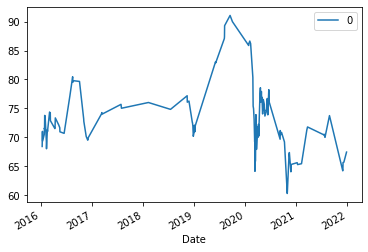

In [280]:
s.loc[oil_pct_index,:].plot()

In [283]:
ex_points_pct.index

DatetimeIndex(['2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29',
               '2016-02-01', '2016-02-10',
               ...
               '2021-03-23', '2021-07-19', '2021-07-20', '2021-07-26',
               '2021-08-27', '2021-11-30', '2021-12-01', '2021-12-02',
               '2021-12-08', '2021-12-27'],
              dtype='datetime64[ns]', name='Date', length=155, freq=None)